## 1. Split train and test data

In [ ]:
import pandas as pd
df = pd.read_csv("data/hate_speech_df.csv")

##### 1.1 Selecting data with class label equals 1 or 2

In [ ]:
# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

df = df[df['class'].isin([1, 2])]

##### 1.2 Shuffle the df

In [ ]:
# prompt: shuffle the df

df = df.sample(frac=1).reset_index(drop=True)

##### 1.3 make the last 1000 rows as test data

In [ ]:
df_test = df.tail(1000)
df_test = df_test[['tweet', 'class']]
df_train = df.iloc[:-1000]
df_train = df_train[['tweet', 'class']]

In [ ]:
# df_test["no_few_shot"] = ""
# df_test["1k"] =""
# df_test["2k"] =""
# df_test["4k"] =""
# df_test["16k"] =""
# df_test["curated_1k"] =""
# df_test["curated_2k"] =""

## 2. Loading the Mistral-7B-Instruct Model

##### 2.1 install dependecies

In [14]:
# !pip install ctransformers[cuda]
# !pip install --upgrade git+https://github.com/huggingface/transformers

##### 2.2 Loading LLM

In [ ]:
from ctransformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GGUF")
config.config.context_length = 2048

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
    model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=65,
    hf=True,
    config=config
)

In [ ]:
from transformers import AutoTokenizer, pipeline

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

# Pipeline
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=1,
    repetition_penalty=1.0
)

## 3. Prompt Generation Templates

##### 3.1 generate prompt with examples

In [ ]:
def generate_prompt(few_shot_example, tweet):
    system_prompt = f"""
    1.Purpose:
      I am a PhD student in computer science researching tweet classification for offensiveness.
      where class equals 1 indicate offensive tweet, class equals 2 indicate normal tweet.
      
    2.Learn From Examples:
        {few_shot_example}
    
    3.Do Not Output:
        '' or any explanation.
        
    4.Output Format:
      1 or 2 only, do not output anything else.
    """
    
    user_query = f"""
    tweet: {tweet}
    class:
    """
    return system_prompt + "\n" + user_query

##### 3.1.1 build examples for prompt with examples

In [ ]:
def build_examples(prompt, df, num):
    for index, row in df.head(num).iterrows():
        prompt += "tweet: " + row['tweet'] + "\n"
        prompt += "class: " + str(row['class']) + "\n"
    return prompt

##### 3.2 generate prompt without example

In [ ]:
def generate_prompt_no_example(tweet):
    system_prompt = """
    1.Purpose:
      I am a PhD student in computer science researching tweet classification for offensiveness.
      where class equals 1 indicate offensive tweet, class equals 2 indicate normal tweet.
    
    2.Do Not Output:
        '' or any explanation.
        
    3.Output Format:
      1 or 2 only, do not output anything else.
    """
    
    user_query = f"""
    tweet: {tweet}
    class:
    """
    return system_prompt + "\n" + user_query

##### 3.2 generate prompt with curated balanced number of positive and negative examples

In [ ]:
def generate_prompt_curated_example(tweet):
    system_prompt = """
    1.Purpose:
      I am a PhD student in computer science researching tweet classification for offensiveness.
      where class equals 1 indicate offensive tweet, class equals 2 indicate normal tweet.
      
    2.Learn From Examples:
        tweet: Josh you're a hoe &#128514;&#128514;&#128514;&#128557;&#128557;&#128557;
        class: 1
        
        tweet: Bust a nicca head,smack a ho,shoot the club up! &#128514; &#128266;&#128266;&#128131;&#128131;&#128131;
        class: 1
        
        tweet: &#8220;@DJ_D_RAC: Fuck driving stick, it's gay as fuck&#8221; shit pussies say
        class: 1
        
        tweet: RT @AZEALIABANKS: Ladies its a full moon. Which means pussy power is in full effect.. yall better get some dick tonnnnniiiiiiggggghhht!!!
        class: 1
        
        tweet: @InFaMouS_StAcKz hell no cause Brad still walked away like " yeah i fucked that niggas bitch " &#128514;
        class: 1
        
        tweet: RT @Anastacia_Cole: I like being Asian and all but it's a struggle having squinty eyes in every picture
        class: 2
        
        tweet: Perhaps Ezra Miller is the first crack toward changing that, regardless of whether he identifies as queer over gay.
        class: 2
        
        tweet: @TheLittleFella_ @OLE_VertyBstard @thereal_EMandM @Justinrogo01 boooooooo that was trash
        class: 2
        
        tweet: RT @morningmoneyben: This image of Peshmerga giving the heave-ho to an ISIS flag really brightened my Friday. Kick their sorry butts!! http&#8230;
        class: 2
        
        tweet: If the Yankees can't beat the Red Sox, they don't even deserve to be in the playoffs #yankees #redsox #mlb
        class: 2
        
        tweet: This bitch weave game serious https://t.co/DRknioe6vh
        class: 1
        
        tweet: Driving the fucktardmobile - tranny slips and all. &#128530; http://t.co/8e3kXEgMjo
        class: 1
        
        tweet: RT @jaaayLENo: Dese hoes aint loyal @ Wal-Mart #TeamIgnant #hoodcomedy #flytv #LOLATL &#128514;&#128514;&#128514;&#128514; bruh https://t.co/3nKvBpR9qr
        class: 1
        
        tweet: Mint Oreos &gt;&gt;&gt;
        class: 2
        
        tweet: They have to. That division is trash @NoMeek_JustMilz: Saints gon win the NFC South...watch
        class: 2
        
        tweet: WH: Obama won&#8217;t name Holder&#8217;s replacement until you rubes have already cast your midterm ballots - Hot Air http://t.co/Yf1o8h99Uz
        class: 2
        
        tweet: so. mad... We live in a world where whitey can go to jail for a word other folks wear right on their hats &amp; tshirts. If I wore that shirt...
        class: 2
        
        tweet: @baaaabyshaaaay_ My niggah!!
        class: 1
        
        tweet: @StudlyDubly Eat my pussy!
        class: 1
        
        tweet: RT @ShelleT1986: Great start the morning! My daughter danced herself into the coffee table and gave herself a nice shiner... Yea she's a wh&#8230;
        class: 2
        
    
    3.Do Not Output:
        '' or any explanation.
        
    4.Output Format:
      1 or 2 only, do not output anything else.
    """
    
    user_query = f"""
    tweet: {tweet}
    class:
    """
    return system_prompt + "\n" + user_query

## 4. Classification

##### 4.1 single tweet classification

In [ ]:
def classify_example_tweet(df_train, tweet, example_num):
    few_shot_example = build_examples(prompt='', df=df_train, num=example_num)
    example_prompt = generate_prompt(few_shot_example, f"""
                    {str(tweet)}
                    """)
    response = generator(example_prompt)
    output = response[0]["generated_text"]
    return output

##### 4.2 multiple tweets classfication

In [ ]:
def classify_multi_tweet(start_index, df, storage_path, col_name, example_num, with_example, with_curated, rerun_list):
    
    few_shot_example = build_examples(prompt='', df=df_train, num=example_num)
    for i in range(start_index, len(df), 50):
        print(f"Processing tweets from {i} to {i+49}")
        for j, tweet in enumerate(df['tweet'][i:i+50]):
            try:
                # Process the tweet using the Perplexity API
                if with_example == True:
                    example_prompt = generate_prompt(few_shot_example, f"""
                    {str(tweet)}
                    """)
                    response = generator(example_prompt)
                    output = response[0]["generated_text"].split("class:")[-1].strip()
                    df.loc[df.index[i + j], col_name] = int(output)
                elif with_curated == True:
                    example_prompt = generate_prompt_curated_example(f"""
                    {tweet}
                    """)
                    response = generator(example_prompt)
                    output = response[0]["generated_text"].split("class:")[-1].strip()
                    df.loc[df.index[i + j], col_name] = int(output)
                else:
                    example_prompt = generate_prompt_no_example(f"""
                    {tweet}
                    """)
                    response = generator(example_prompt)
                    output = response[0]["generated_text"].split("class:")[-1].strip()
                    df.loc[df.index[i + j], col_name] = int(output)
                # print(extracted_text)
            except Exception as e:
                print(f"Error processing tweet {i+j}: {e}")
                rerun_list.append(int(i+j))
        df.to_csv(storage_path, index=False)
        print("saved")

    df.to_csv(storage_path, index=False)

##### 4.3 classification for all context length

In [ ]:
col_list = ['no_few_shot','1k','2k','4k','16k','curated_1k','curated_2k']
def classification_all(col_list):
    rerun_dict = {}
    example_config = {'no_few_shot': 0,
                      '1k': 18,
                      '2k': 40,
                      '4k': 100,
                      '16k': 400,
                      'curated_1k': 18,
                      'curated_2k': 40
                     }
    for col_name in col_list:
        with_example = col_name in ["1k", "2k", "4k", "16k"]
        with_curated = col_name in ["curated_1k", "curated_2k"]
        rerun_dict['col_name'] = []
        classify_multi_tweet(start_index=0,
                             df=df_test,
                             storage_path='data/df_test.csv',
                             col_name=col_name,
                             example_num=example_config[col_name],
                             with_example=with_example,
                             with_curated=with_curated,
                             rerun_list=rerun_dict['col_name']
                             )

## 5. Visualization

In [15]:
import pandas as pd

df_test = pd.read_csv("data/df_test.csv")

In [17]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Convert 'class' column to binary
df_test_copy = df_test.copy()
df_test_copy['class'] = df_test_copy['class'].map({1: 1, 2: 0})
df_test_copy['1k'] = df_test_copy['1k'].map({1: 1, 2: 0})
df_test_copy['2k'] = df_test_copy['2k'].map({1: 1, 2: 0})
df_test_copy['4k'] = df_test_copy['4k'].map({1: 1, 2: 0})
df_test_copy['curated_1k'] = df_test_copy['curated_1k'].map({1: 1, 2: 0})
df_test_copy['curated_2k'] = df_test_copy['curated_2k'].map({1: 1, 2: 0})
df_test_copy['no_few_shot'] = df_test_copy['no_few_shot'].map({1: 1, 2: 0})

# Extracting relevant columns
actual_class = df_test_copy['class']
predicted_1k = df_test_copy['1k']
predicted_2k = df_test_copy['2k']
predicted_4k = df_test_copy['4k']
predicted_curated_1k = df_test_copy['curated_1k']
predicted_curated_2k = df_test_copy['curated_2k']
predicted_no_few_shot = df_test_copy['no_few_shot']

# Computing metrics for 1k
accuracy_1k = accuracy_score(actual_class, predicted_1k)
recall_1k = recall_score(actual_class, predicted_1k)
f1_1k = f1_score(actual_class, predicted_1k)

# Computing metrics for 2k
accuracy_2k = accuracy_score(actual_class, predicted_2k)
recall_2k = recall_score(actual_class, predicted_2k)
f1_2k = f1_score(actual_class, predicted_2k)

# Computing metrics for 4k
accuracy_4k = accuracy_score(actual_class, predicted_4k)
recall_4k = recall_score(actual_class, predicted_4k)
f1_4k = f1_score(actual_class, predicted_4k)

# Computing metrics for curated_1k
accuracy_curated_1k = accuracy_score(actual_class, predicted_curated_1k)
recall_curated_1k = recall_score(actual_class, predicted_curated_1k)
f1_curated_1k = f1_score(actual_class, predicted_curated_1k)

# Computing metrics for curated_2k
accuracy_curated_2k = accuracy_score(actual_class, predicted_curated_2k)
recall_curated_2k = recall_score(actual_class, predicted_curated_2k)
f1_curated_2k = f1_score(actual_class, predicted_curated_2k)

# Computing metrics for no_few_shot
accuracy_no_few_shot = accuracy_score(actual_class, predicted_no_few_shot)
recall_no_few_shot = recall_score(actual_class, predicted_no_few_shot)
f1_no_few_shot = f1_score(actual_class, predicted_no_few_shot)

# Displaying the results
print("\nMetrics for no_few_shot:")
print("Accuracy:", accuracy_no_few_shot)
print("Recall:", recall_no_few_shot)
print("F1-score:", f1_no_few_shot)

print("\nMetrics for 1k:")
print("Accuracy:", accuracy_1k)
print("Recall:", recall_1k)
print("F1-score:", f1_1k)

print("\nMetrics for 2k:")
print("Accuracy:", accuracy_2k)
print("Recall:", recall_2k)
print("F1-score:", f1_2k)

print("\nMetrics for 4k:")
print("Accuracy:", accuracy_4k)
print("Recall:", recall_4k)
print("F1-score:", f1_4k)

print("\nMetrics for curated_1k:")
print("Accuracy:", accuracy_curated_1k)
print("Recall:", recall_curated_1k)
print("F1-score:", f1_curated_1k)

print("\nMetrics for curated_2k:")
print("Accuracy:", accuracy_curated_2k)
print("Recall:", recall_curated_2k)
print("F1-score:", f1_curated_2k)


Metrics for no_few_shot:
Accuracy: 0.834
Recall: 0.9976076555023924
F1-score: 0.9094874591057798

Metrics for 1k:
Accuracy: 0.839
Recall: 0.9940191387559809
F1-score: 0.911684037301152

Metrics for 2k:
Accuracy: 0.841
Recall: 0.9880382775119617
F1-score: 0.9122032026504694

Metrics for 4k:
Accuracy: 0.833
Recall: 0.9916267942583732
F1-score: 0.9084931506849315

Metrics for curated_1k:
Accuracy: 0.868
Recall: 0.9366028708133971
F1-score: 0.9222614840989399

Metrics for curated_2k:
Accuracy: 0.856
Recall: 0.9210526315789473
F1-score: 0.9144893111638954


##### 5.1 Experiments Results

In [19]:
from tabulate import tabulate

# ... (your code for calculating metrics) ...

# Create a list of lists to hold the table data
table_data = [
    ["Context Length", "Accuracy", "Recall", "F1-score"],
    ["no_few_shot", accuracy_no_few_shot, recall_no_few_shot, f1_no_few_shot],
    ["1k", accuracy_1k, recall_1k, f1_1k],
    ["2k", accuracy_2k, recall_2k, f1_2k],
    ["4k", accuracy_4k, recall_4k, f1_4k],
    ["curated_1k", accuracy_curated_1k, recall_curated_1k, f1_curated_1k],
    ["curated_2k", accuracy_curated_2k, recall_curated_2k, f1_curated_2k]
]

# Print the formatted table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒══════════════════╤════════════╤══════════╤════════════╕
│ Context Length   │   Accuracy │   Recall │   F1-score │
╞══════════════════╪════════════╪══════════╪════════════╡
│ no_few_shot      │      0.834 │ 0.997608 │   0.909487 │
├──────────────────┼────────────┼──────────┼────────────┤
│ 1k               │      0.839 │ 0.994019 │   0.911684 │
├──────────────────┼────────────┼──────────┼────────────┤
│ 2k               │      0.841 │ 0.988038 │   0.912203 │
├──────────────────┼────────────┼──────────┼────────────┤
│ 4k               │      0.833 │ 0.991627 │   0.908493 │
├──────────────────┼────────────┼──────────┼────────────┤
│ curated_1k       │      0.868 │ 0.936603 │   0.922261 │
├──────────────────┼────────────┼──────────┼────────────┤
│ curated_2k       │      0.856 │ 0.921053 │   0.914489 │
╘══════════════════╧════════════╧══════════╧════════════╛


##### 5.2 bar plot for 'no_few_shot', '1k', '2k', '4k'

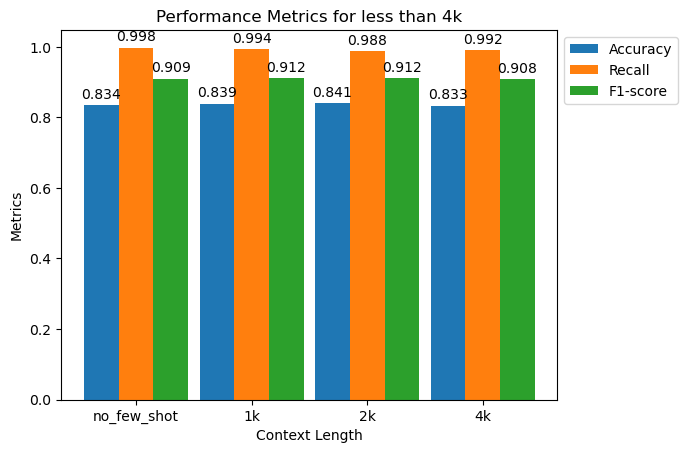

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Data for context length less than 4k
selected_labels = ['no_few_shot', '1k', '2k', '4k']
selected_accuracy = [0.834, 0.839, 0.841, 0.833]
selected_recall = [0.997608, 0.994019, 0.988038, 0.991627]
selected_f1_score = [0.909487, 0.911684, 0.912203, 0.908493]

# Bar width
bar_width = 0.3

# Set up the bar positions
r1 = np.arange(len(selected_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bar plots
plt.bar(r1, selected_accuracy, width=bar_width, label='Accuracy')
plt.bar(r2, selected_recall, width=bar_width, label='Recall')
plt.bar(r3, selected_f1_score, width=bar_width, label='F1-score')

# Add labels on each bar
for i, value in enumerate(selected_accuracy):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')
for i, value in enumerate(selected_recall):
    plt.text(i + bar_width, value + 0.01, f'{value:.3f}', ha='center', va='bottom')
for i, value in enumerate(selected_f1_score):
    plt.text(i + 2 * bar_width, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Add labels, title, and legend with adjustments
plt.xlabel('Context Length')
plt.xticks([r + bar_width for r in range(len(selected_labels))], selected_labels)
plt.ylabel('Metrics')
plt.title('Performance Metrics for less than 4k')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Show the plot
plt.show()

##### 5.3 bar plot for 1k and 2k with and without curated examples

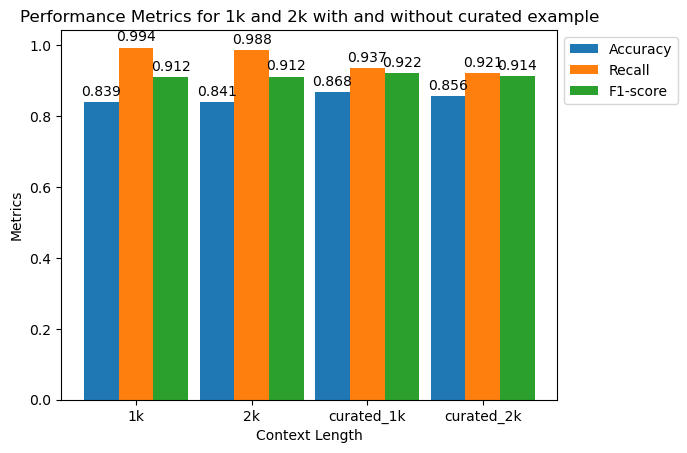

In [34]:
# Data for 1k and 2k with and without curated example
selected_labels = ['1k', '2k', 'curated_1k', 'curated_2k']
selected_accuracy = [0.839, 0.841, 0.868, 0.856]
selected_recall = [0.994019, 0.988038, 0.936603, 0.921053]
selected_f1_score = [0.911684, 0.912203, 0.922261, 0.914489]

# Bar width
bar_width = 0.3

# Set up the bar positions
r1 = np.arange(len(selected_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bar plots
plt.bar(r1, selected_accuracy, width=bar_width, label='Accuracy')
plt.bar(r2, selected_recall, width=bar_width, label='Recall')
plt.bar(r3, selected_f1_score, width=bar_width, label='F1-score')

# Add labels on each bar
for i, value in enumerate(selected_accuracy):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')
for i, value in enumerate(selected_recall):
    plt.text(i + bar_width, value + 0.01, f'{value:.3f}', ha='center', va='bottom')
for i, value in enumerate(selected_f1_score):
    plt.text(i + 2 * bar_width, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Add labels, title, and legend with adjustments
plt.xlabel('Context Length')
plt.xticks([r + bar_width for r in range(len(selected_labels))], selected_labels)
plt.ylabel('Metrics')
plt.title('Performance Metrics for 1k and 2k with and without curated example')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Show the plot
plt.show()

## rerun

In [ ]:
rerun_list = []
classify_multi_tweet(start_index=0,
                     df=df_test,
                     storage_path='data/df_test.csv',
                     col_name='curated_2k',
                     example_num=20,
                     with_example=False,
                     with_curated=True,
                     rerun_list=rerun_list
                     )

In [ ]:
# df_test.loc[df_test.index[699], '16k'] = int(1)

In [ ]:
idx=293
col_name='curated_1k'
tweet = df_test.loc[df_test.index[idx], 'tweet']
example_prompt = generate_prompt_curated_example(f"""
{tweet}
""")
response = generator(example_prompt)
output = response[0]["generated_text"].split("class:")[-1].strip()
print(output)
df_test.loc[df_test.index[idx], col_name] = int(output)
print(df_test.loc[df_test.index[idx], col_name])

In [ ]:
idx=293
col_name='curated_1k'
few_shot_example = build_examples(prompt='', df=df_train, num=360)
tweet = df_test.loc[df_test.index[idx], 'tweet']
example_prompt = generate_prompt(few_shot_example, f"""
{tweet}
""")
response = generator(example_prompt)
output = response[0]["generated_text"].split("class:")[-1].strip()
print(output)
df_test.loc[df_test.index[idx], col_name] = int(output)
print(df_test.loc[df_test.index[idx], col_name])

In [ ]:
def rerun_curated(rerun_list, df, storage_path, col_name):
    for idx in rerun_list:
        tweet = df.loc[df.index[idx], 'tweet']
        example_prompt = generate_prompt_curated_example(f"""
        {tweet}
        """)
        response = generator(example_prompt)
        output = response[0]["generated_text"].split("class:")[-1].strip()
        try:
            df.loc[df.index[idx], col_name] = int(output)
            rerun_list = [x for x in rerun_list if x != idx]
        except Exception as e:
            print(f"Error processing tweet {idx}: {e}")

    df.to_csv(storage_path, index=False)
    
rerun_curated(rerun_list=rerun_list, 
              df=df_test, 
              storage_path="data/df_test.csv",
              col_name='curated_2k'
              )

In [ ]:
def rerun(rerun_list, df, storage_path, col_name, example_num):
    few_shot_example = build_examples(prompt='', df=df_train, num=example_num)
    for idx in rerun_list:
        tweet = df.loc[df.index[idx], 'tweet']
        example_prompt = generate_prompt(few_shot_example, f"""
        {tweet}
        """)
        response = generator(example_prompt)
        output = response[0]["generated_text"].split("class:")[-1].strip()
        try:
            df.loc[df.index[idx], col_name] = int(output)
            rerun_list = [x for x in rerun_list if x != idx]
        except Exception as e:
            print(f"Error processing tweet {idx}: {e}")

    df.to_csv(storage_path, index=False)
    
rerun(rerun_list=rerun_list, 
      df=df_test, 
      storage_path="data/df_test.csv",
      col_name='16k',
      example_num=360,)

In [ ]:
df_test['tweet'][22389]